Roboflow Object Detection with Adversarial Attacks

This script demonstrates:
1. Downloading a dataset from Roboflow
2. Creating a custom dataset loader for COCO format
3. Training or loading a Faster R-CNN model
4. Generating adversarial examples using FGSM
5. Evaluating model performance on clean and adversarial examples

Requirements:
- torch
- torchvision
- roboflow
- pycocotools
- matplotlib

In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt

In [12]:
# Configuration - should be moved to a config file in production
CONFIG = {
    "api_key": "DEox6oznQeGVSq8h49uK",  # Note: In production, use environment variables
    "workspace": "school-ny3mt",
    "project": "hepsi-humo1",
    "version": 2,
    "data_dir": "./hepsi-2",
    "num_classes": 15,
    "batch_size": 1,
    "num_epochs": 1,
    "learning_rate": 0.01,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "model_save_path": "cnn_model.pth",
    "epsilon": 0.3  # For FGSM attack
}

In [3]:
class RoboDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for Roboflow COCO formatted data.
    
    Args:
        root (str): Path to the image directory
        annotation (str): Path to the COCO annotation file
        transforms (callable, optional): Optional transforms to be applied
    """
    
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        """
        Loads and returns a sample from the dataset at the given index.
        
        Args:
            index (int): Index
            
        Returns:
            tuple: (image, target) where target is a dictionary containing:
                - boxes (FloatTensor[N, 4]): the ground-truth boxes in [xmin, ymin, xmax, ymax] format
                - labels (Int64Tensor[N]): the class label for each ground-truth box
                - image_id (Int64Tensor[1]): an identifier for the image
                - area (Tensor[N]): The area of the bounding box
                - iscrowd (UInt8Tensor[N]): iscrowd flag
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)

        # Convert COCO bbox format [xmin, ymin, width, height] to PyTorch format [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin, ymin, width, height = coco_annotation[i]['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([ann['category_id'] for ann in coco_annotation], dtype=torch.int64)
        img_id = torch.tensor([img_id])
        areas = torch.as_tensor([ann['area'] for ann in coco_annotation], dtype=torch.float32)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": img_id,
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [4]:

def get_transform():
    """Basic transform to convert PIL Image to Tensor"""
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

def get_model_instance_segmentation(num_classes):
    """
    Initialize a Faster R-CNN model with a custom head for the given number of classes.
    
    Args:
        num_classes (int): Number of output classes
        
    Returns:
        model (torch.nn.Module): Initialized Faster R-CNN model
    """
    # Load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    
    # Replace the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

def fast_gradient_sign_method(model, images, targets, epsilon=0.15):
    """
    Fast Gradient Sign Method (FGSM) attack for object detection models.
    
    Args:
        model (torch.nn.Module): The model to attack
        images (Tensor): Input images
        targets (list[dict]): Target annotations
        epsilon (float): Attack strength
        
    Returns:
        tuple: (adversarial_images, noise)
    """
    # Set model to training mode to enable gradient computation
    model.train()
    
    # Clone images and enable gradient tracking
    perturbed_images = images.clone().requires_grad_()
    
    # Forward pass
    loss_dict = model(perturbed_images, targets)
    losses = sum(loss for loss in loss_dict.values())
    
    # Backward pass to compute gradients
    model.zero_grad()
    losses.backward()
    
    # Create adversarial examples
    noise = torch.sign(perturbed_images.grad.data)
    adversarial_images = images + epsilon * noise
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Maintain valid pixel range
    
    # Set model back to eval mode
    model.eval()
    
    return adversarial_images.detach(), noise.detach()

def train_model(model, data_loader, device, num_epochs=10):
    """Training loop for the object detection model"""
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, 
        lr=CONFIG['learning_rate'],
        momentum=CONFIG['momentum'],
        weight_decay=CONFIG['weight_decay']
    )
    
    model.train()
    for epoch in range(num_epochs):
        for i, (images, targets) in enumerate(data_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Skip empty targets
            if targets[0]['boxes'].size()[0] == 0:
                continue
                
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            print(f'Epoch: {epoch}, Iteration: {i}/{len(data_loader)}, Loss: {losses.item()}')

Using device: cuda
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading pretrained model...


C:\Users\ISEC\AppData\Local\Temp\ipykernel_31156\1637518226.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CONFIG['model_save_path']))

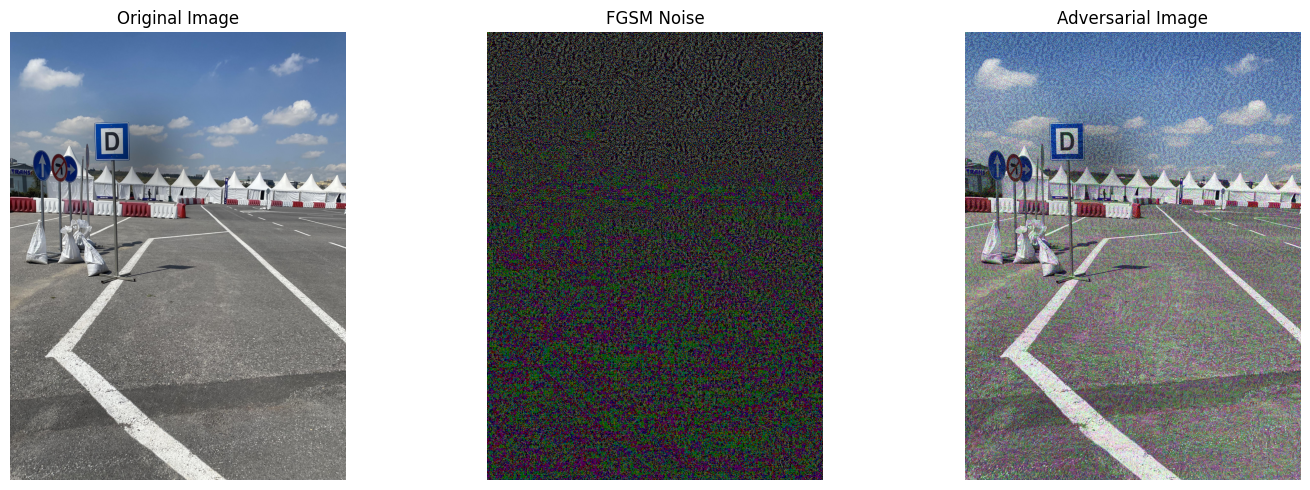


Original image predictions:
tensor(13, device='cuda:0')

Adversarial image predictions:
tensor(8, device='cuda:0')


In [ ]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets and data loaders
train_dataset = RoboDataset(
    root=os.path.join(CONFIG['data_dir'], 'train'),
    annotation=os.path.join(CONFIG['data_dir'], 'train/_annotations.coco.json'),
    transforms=get_transform()
)

test_dataset = RoboDataset(
root=os.path.join(CONFIG['data_dir'], 'test'),
annotation=os.path.join(CONFIG['data_dir'], 'test/_annotations.coco.json'),
    transforms=get_transform()
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Initialize model
model = get_model_instance_segmentation(CONFIG['num_classes'])
model.to(device)

# Train or load model
if False:  # Set to False to load pretrained model
    print("Training model...")
    train_model(model, train_loader, device, CONFIG['num_epochs'])
    torch.save(model.state_dict(), CONFIG['model_save_path'])
else:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(CONFIG['model_save_path']))

model.eval()

# Get a test sample
test_images, test_targets = next(iter(test_loader))
test_images = list(img.to(device) for img in test_images)
test_targets = [{k: v.to(device) for k, v in t.items()} for t in test_targets]

# Generate adversarial example
adv_images, noise = fast_gradient_sign_method(
    model,
    test_images[0].unsqueeze(0),
    test_targets,
    epsilon=CONFIG['epsilon']
)

# Visualize results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(test_images[0].cpu().numpy().transpose(1, 2, 0))
plt.title("Original Image")
plt.axis('off')

# Noise
plt.subplot(1, 3, 2)
plt.imshow(noise[0].cpu().numpy().transpose(1, 2, 0))
plt.title("FGSM Noise")
plt.axis('off')

# Adversarial image
plt.subplot(1, 3, 3)
plt.imshow(adv_images[0].cpu().numpy().transpose(1, 2, 0))
plt.title("Adversarial Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluate predictions
with torch.no_grad():
    print("\nOriginal image predictions:")
    orig_preds = model(test_images[0].unsqueeze(0))
    print(orig_preds[0]["labels"][0])
    
    print("\nAdversarial image predictions:")
    adv_preds = model(adv_images)
    print(adv_preds[0]["labels"][0])